In [1]:
# ===================================================================
#               Importamos las librerias a utilizar
# ===================================================================

from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city, plot_histogram
from qiskit_aer import AerSimulator 
import matplotlib.pyplot as plt
import numpy as np
from qiskit import transpile

Circuito para Fotón Horizontal |H> (estado |0>)


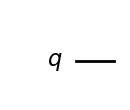


Circuito para Fotón Vertical |V> (estado |1>)


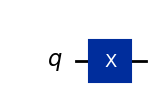


Circuito para Fotón Diagonal |D> (estado |+>)


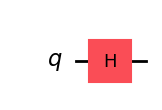

In [ ]:
# ===================================================================
#                   Definición de los estados de fotones
# ===================================================================

# --- Estado 1: Fotón Horizontal |H> ---
qc_h = QuantumCircuit(1)

# --- Estado 2: Fotón Vertical |V> ---
qc_v = QuantumCircuit(1)

# Para |1>, aplicamos una puerta NOT (o Pauli-X) al qubit |0>
qc_v.x(0) # X es la compuerta NOT

# --- Estado 3: Fotón Diagonal |D> ---
# Para |D> (Diagonal), creamos una superposición de |0> y |1>
# Usamos la compuerta Hadamard (H)
qc_d = QuantumCircuit(1)
qc_d.h(0) # H crea el estado (|0> + |1>)/sqrt(2)

# --- Gráfiac de los circuitos ---
print("Circuito para Fotón Horizontal |H> (estado |0>)")
display(qc_h.draw('mpl'))

print("\nCircuito para Fotón Vertical |V> (estado |1>)")
display(qc_v.draw('mpl'))

print("\nCircuito para Fotón Diagonal |D> (estado |+>)")
display(qc_d.draw('mpl'))

Circuito para Entrelazar dos 'Fotones' (Estado de Bell |Φ+>)


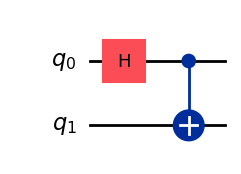

In [5]:
# ===================================================================
#                  Entrelazamiento de dos fotones
# ===================================================================

# --- Circuito para crear el Estado de Bell |Φ+> ---
qc_bell = QuantumCircuit(2)

# 1. Poner el qubit de Alice (q0) en superposición
qc_bell.h(0)  # Hadamard en el qubit 0

# 2. Conectar el qubit de Bob (q1) al de Alice
qc_bell.cx(0, 1) # CNOT(control=0, objetivo=1)

# --- Dibujemos el circuito de entrelazamiento ---
print("Circuito para Entrelazar dos 'Fotones' (Estado de Bell |Φ+>)")
display(qc_bell.draw('mpl'))

In [2]:
# ===================================================================
#           Configuración de la Prueba CHSH (Protocolo E91)
# ===================================================================


def crear_circuito_chsh(base_alice, base_bob):
    #Crea un circuito CHSH basado en las elecciones de base de Alice y Bob.
  
    qc = QuantumCircuit(2, 2)
    
    # Alice y Bob comparten un par entrelazado |Phi+>
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()
    
    # ELECCIÓN DE BASES (Rotaciones antes de medir)
    
    # Rotaciones de Alice
    if base_alice == 0:
        pass # Base Z (Estándar): No se rota
    elif base_alice == 1:
        qc.h(0) # Base X: Se aplica Hadamard
        
    # Rotaciones de Bob (Para maximizar la violación CHSH)
    if base_bob == 0:
        # Rota a pi/8 (Base W)
        qc.ry(-np.pi/4, 1) 
    elif base_bob == 1:
        # Rota a -pi/8 (Base V)
        qc.ry(np.pi/4, 1)
        
    # MEDICIÓN
    qc.measure([0, 1], [0, 1])
    
    return qc

In [3]:
# ===================================================================
#                Ejecución de los 4 escenarios
# ===================================================================

# Definimos las 4 combinaciones de bases posibles para calcular S
# (A1, B1), (A1, B2), (A2, B1), (A2, B2)
circuitos = []
etiquetas = []

bases = [(0, 0), (0, 1), (1, 0), (1, 1)] # Pares (Alice, Bob)

for a, b in bases:
    qc = crear_circuito_chsh(a, b)
    circuitos.append(qc)
    etiquetas.append(f"A{a}B{b}")

# Simulamos
simulador = AerSimulator()
circuitos_compilados = transpile(circuitos, simulador)
job = simulador.run(circuitos_compilados, shots=1000)
resultados = job.result()

# ===================================================================
#           Paso 4: Cálculo de la Correlación E
# ===================================================================

def calcular_E(conteos):
    """
    Calcula el valor esperado E = (P00 + P11) - (P01 + P10)
    Pij es la probabilidad de que Alice mida i y Bob mida j.
    """
    shots = sum(conteos.values())
    P00 = conteos.get('00', 0) / shots
    P11 = conteos.get('11', 0) / shots
    P01 = conteos.get('01', 0) / shots
    P10 = conteos.get('10', 0) / shots
    
    # Correlación: Coincidencias - Discrepancias
    return (P00 + P11) - (P01 + P10)

# Calculamos S
E_val = []
for i, etiqueta in enumerate(etiquetas):
    conteos = resultados.get_counts(i)
    E = calcular_E(conteos)
    E_val.append(E)
    print(f"Correlación E({etiqueta}): {E:.4f}")

# Fórmula CHSH: S = E(A0,B0) - E(A0,B1) + E(A1,B0) + E(A1,B1)
# Nota: El signo menos puede variar según la definición exacta de los ángulos,
# pero buscamos la magnitud |S|.
S = E_val[0] - E_val[1] + E_val[2] + E_val[3]

print(f"\nValor S calculado: {abs(S):.4f}")
print(f"Límite Clásico: 2.0")
print(f"Límite Cuántico (Tsirelson): {2*np.sqrt(2):.4f}")

if abs(S) > 2:
    print(">>> VIOLACIÓN DE DESIGUALDAD DE BELL: CANAL SEGURO (Cuántico)")
else:
    print(">>> NO HAY VIOLACIÓN: POSIBLE ESPIONAJE (Clásico)")

Correlación E(A0B0): 0.6640
Correlación E(A0B1): 0.6920
Correlación E(A1B0): 0.6860
Correlación E(A1B1): -0.7320

Valor S calculado: 0.0740
Límite Clásico: 2.0
Límite Cuántico (Tsirelson): 2.8284
>>> NO HAY VIOLACIÓN: POSIBLE ESPIONAJE (Clásico)


In [ ]:
# ===================================================================
#       Escenario 1: Canal Seguro (AerSimulator Ideal)
# ===================================================================

# 1. Definir las 4 combinaciones de medición para CHSH
combinaciones = [(0, 0), (0, 1), (1, 0), (1, 1)]
circuitos_ideales = [crear_circuito_chsh(a, b) for a, b in combinaciones]

# 2. Configurar simulador ideal (SIN ruido)
simulador_ideal = AerSimulator()

# 3. Ejecutar
job_ideal = simulador_ideal.run(transpile(circuitos_ideales, simulador_ideal), shots=1000)
res_ideal = job_ideal.result()

# 4. Calcular S
s_ideal = calcular_valor_S(res_ideal)

print(f"--- RESULTADO ESCENARIO 1: CANAL SEGURO ---")
print(f"Valor S calculado: {s_ideal:.4f}")
print(f"¿Viola la desigualdad clásica (> 2)? {'SÍ' if s_ideal > 2 else 'NO'}")
print(f"Referencia Teórica: ~2.828 (2√2)\n")